#  <center> Problem Set 2 <center>
<center> 3.C01/3.C51, 7.C01/7.C51, 10.C01/10.C51, 20.C01/20.C51<center>

<b>Name:</b>

<b>Kerberos id:</b>

### Download required data & install packages

In [1]:
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps2-bio/data/dna_binding.csv
!wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps2-bio/data/cell_segmentation_jpeg.tar.gz
!tar -xf cell_segmentation_jpeg.tar.gz

--2025-04-13 20:49:28--  https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps2-bio/data/dna_binding.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1408340 (1.3M) [text/plain]
Saving to: ‘dna_binding.csv’

dna_binding.csv     100%[===================>]   1.34M  --.-KB/s    in 0.05s   

2025-04-13 20:49:29 (28.9 MB/s) - ‘dna_binding.csv’ saved [1408340/1408340]

--2025-04-13 20:49:29--  https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps2-bio/data/cell_segmentation_jpeg.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiti

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision.models import vgg16
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.utils import shuffle
import glob

import os
import PIL
from PIL import Image
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import imageio
from skimage import io, color



matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

## <center>Problem 1: Predicting DNA Binding Sites</center>

In [3]:
df = pd.read_csv("./dna_binding.csv")

sequences = df.seq.values
y = df.bind.values

In [4]:
df

,Unnamed: 0,seq,bind
0,0,TTGGTCGGCAACCTGTCCCTCCTGCTCATGTGATGCGGCACGTGAC...,1
1,1,GCTGCGGGGCAACAACCCTCGCTGCCAACACCCGTACTGGCGGGGT...,0
2,2,CTCCCCTCTCGGAGGGGGCTGGCCACGTGAGACCCTGGTCAGGTGA...,1
3,3,GTGCGGCACCACCGGGGGGGACCTCCGCCGCCTCGAATGGTTCCAA...,0
4,4,CCGGGTCACGTGGGTCCAGGGTCACGTGCCGCTGCGGGTCACGTGC...,1
...,...,...,...
12899,12899,GCCCTGAGAAGCACCAGTACGGTTTGTTGGGCATGACCGAGGGGGT...,0
12900,12900,CTGAAAAAGCATGATGTGTGGAGTTCGATTTGAAACACGGCCAGGG...,1
12901,12901,GGCCAGAGCTATTGCCGGCCGTTGTGTGACGAAACAATTAGGATTG...,0
12902,12902,GTTCTTAGTGTACAGAAGAGTATTCTGGGGAGGAGGCTGAGGAAGG...,1


### 1.1 (20 points) Build Datasets and DataLoaders in PyTorch

One-hot encode DNA sequence data.

In [5]:
def SeqEnc(sequences):
    '''
    A function to one-hot encode DNA sequences

    Args:
        sequences (list): list of DNA sequences

    Returns:
        np.array: array with shape (N,C,4) where N is the number of sequences
        and C is the sequence length
    '''
    ################ Code #################
    base_to_idx = {'A': 0, 'T': 1, 'G': 2, 'C': 3}

    N = len(sequences)
    C = len(sequences[0])

    one_hot = np.zeros((N, C, 4), dtype=np.float32)

    for i, seq in enumerate(sequences):
        for j, base in enumerate(seq):
            if base in base_to_idx:
                one_hot[i, j, base_to_idx[base]] = 1.0

    return one_hot
    ################ Code #################

In [10]:
SeqEnc(['TTGGG','ATACG']).shape

(2, 5, 4)

Implement your dataset class that takes in your data.

In [12]:
# Generate dataset
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))  # store X as a pytorch Tensor
        self.y = torch.Tensor(np.array(y))  # store y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data

    def __getitem__(self, index):
        # your implementation here:
        return self.X[index], self.y[index]
    def __len__(self):
        return self.len

Define your Datasets and DataLoaders.

In [14]:
# Define dataset
sequences = df['seq'].tolist()
labels = df['bind'].tolist()
X_encoded = SeqEnc(sequences)
y_array = np.array(labels)
# 80% trainval, 20% test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_encoded, y_array, test_size=0.2, random_state=42)
# From trainval, take 10% as val (i.e. 8% of total)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=42)

# Build Dataset
train_data = SequenceDataset(X_train, y_train)
val_data = SequenceDataset(X_val, y_val)
test_data = SequenceDataset(X_test, y_test)

# Build DataLoader
batch_size = 256
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

What is the benefit of batching your data into mini-batches versus using the entire dataset to optimize the model all at once?

Mini-batches allow training on datasets that would not fit entirely in memory (especially on GPU) as well as help improve generalization.

### 1.2 (20 points) Build an LSTM-based binding classifier

The following example will help familiarize you with the LSTM.

In [16]:
# Define a LSTM module
lstm_model = nn.LSTM(input_size=4, hidden_size=16, num_layers=1, batch_first=True, bidirectional=True).to("cpu") # "cpu" is the device id

# Send your batch to a GPU
X_batch, y_batch = next(iter(train_loader))
X_batch = X_batch.to("cpu")
y_batch = y_batch.to("cpu")

# Propagate your batch into your model
lstm_out, (ht, ct) = lstm_model(X_batch)
print(lstm_out.shape, ht.shape, ct.shape)

# You can play with hyperparameters to see how your output change

torch.Size([256, 101, 32]) torch.Size([2, 256, 16]) torch.Size([2, 256, 16])


Now build your LSTM-based classifier as a nn.Module.

In [ ]:
import torch
import torch.nn as nn

class LSTMseq(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        # LSTM module: bidirectional=True, batch_first=True, num_layers=1
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=1, batch_first=True, bidirectional=True)

        # MLP regressor: hidden_dim → hidden_dim → 1
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        # Sigmoid to map to probabilities
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim=4)
        lstm_out, (ht, ct) = self.lstm(x)

        # ht shape: (2, batch_size, hidden_dim) → [0]=forward, [1]=backward
        # Use backward final hidden state
        h_backward = ht[1]  # shape: (batch_size, hidden_dim)

        # Pass through MLP
        out = self.mlp(h_backward)

        # Apply sigmoid to get probabilities
        proba = self.sigmoid(out).squeeze(1)  # final shape: (batch_size,)

        return proba


In [19]:
class LSTMseq(torch.nn.Module) :
    def __init__(self, input_dim, hidden_dim) :
        super().__init__()

        # Define a LSTM module
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=1, batch_first=True, bidirectional=True)
        # Define a MLP regressor
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        # Define a sigmoid transform
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # Apply LSTM
        lstm_out, (ht, ct) = self.lstm(x)

        # Pass output into a MLP
        h_backward = ht[1]
        out = self.mlp(h_backward)

        # Return probabilities
        proba = self.sigmoid(out)

        return proba

In [20]:
# Test your ouput on a batch
clf = LSTMseq(input_dim=4, hidden_dim=16).to('cpu')
print(clf(X_batch).shape)

torch.Size([256, 1])


### 1.3 (20 points) Implement functions for training and testing

The training and validation loops and evaluation function.

In [21]:
def train(model, dataloader, optimizer, device):

    '''
    A function to train on the entire dataset for one epoch.

    Args:
        model (torch.nn.Module): Your sequence classifier
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization
        device (str): Your device

    Returns:
        float: loss averaged over all the batches

    '''

    batch_loss = []
    model.train() # Set model to training mode

    for batch in dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)

        # train your model on each batch here
        optimizer.zero_grad()
        output = model(seq)
        loss = F.binary_cross_entropy(output, label.unsqueeze(1))
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    return sum(batch_loss) / len(batch_loss)

def validate(model, dataloader, device):

    '''
    A function to validate on the validation dataset for one epoch.

    Args:
        model (torch.nn.Module): Your sequence classifier
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device

    Returns:
        float: loss averaged over all the batches

    '''

    val_loss = []
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)

            # validate your model on each batch here
            output = model(seq)
            loss = F.binary_cross_entropy(output, label.unsqueeze(1))
            val_loss.append(loss.item())

    return sum(val_loss) / len(val_loss)

def evaluate(model, dataloader, device):

    '''
    A function to return the classification probabilities and true labels (for evaluation).

    Args:
        model (torch.nn.Module): your sequence classifier
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        device (str): Your device

    Returns:
        (np.array, np.array): true labels, predicted probabilities
    '''

    pred_prob = []
    labels = []
    with torch.no_grad():
        model.eval()
        for batch in dataloader:
            epoch_loss = []
            seq, label = batch

            seq = seq.to(device)
            label = label.to(device)

            # evaluate your model here
            output = model(seq)
            pred_prob.append(output.cpu())
            labels.append(label.cpu())

    pred_prob = torch.cat(pred_prob, dim=0).numpy().flatten()
    labels = torch.cat(labels, dim=0).numpy().flatten()

    return labels, pred_prob

In [22]:
device = 'cuda:0'
model = LSTMseq(4, 16).to(device)

optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, factor=0.5)

val_loss_curve = []
train_loss_curve = []

# Use tqdm for progress bar
tqdm_progress =  tqdm(range(500), desc="Progress")

for epoch in tqdm_progress:
    # Compute train your model on training data
    epoch_loss = train(model, train_loader, optimizer,  device=device)

    # Validate your on validation data
    val_loss = validate(model, val_loader, device=device)

    # Record train and loss performance
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)

    # The learning rate scheduler record the validation loss
    scheduler.step(val_loss)
    tqdm_progress.set_postfix(train_loss=f'{epoch_loss:.3f}', val_loss=f'{val_loss:.3f}', refresh=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Progress: 100%|██████████| 500/500 [01:37<00:00,  5.13it/s, train_loss=0.177, val_loss=0.238]


Plot train and validation loss functions.

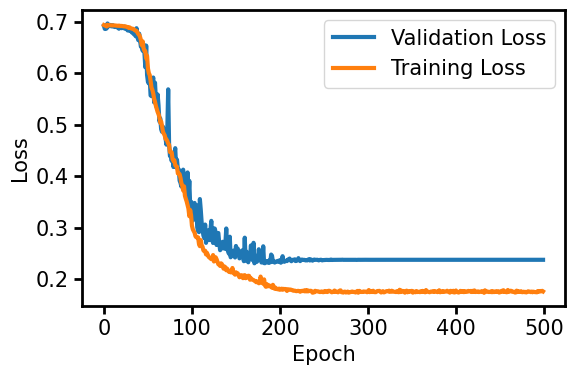

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(val_loss_curve, label='Validation Loss')
ax.plot(train_loss_curve, label='Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
fig.tight_layout()

Report the AUC on test data.


In [24]:
# from sklearn.metrics import roc_auc_score

true_labels, pred_probs = evaluate(model, test_loader, device)
test_auc = roc_auc_score(true_labels, pred_probs)

print(f"Final Test AUC: {test_auc:.4f}")

Final Test AUC: 0.9570


## Problem 2: Image Segmentation

### 2.1 (20 points) Build Datasets and DataLoaders

Parse data from image filepaths.

In [25]:
paths = [path for path in glob.glob("cell_segmentation/*") if "cells" in path]

def load_img(path):
    x = np.array(Image.open(path)) / 255
    y = np.array(Image.open(path.replace("cells","masks"))) / 255
    return x, y

Load one image.


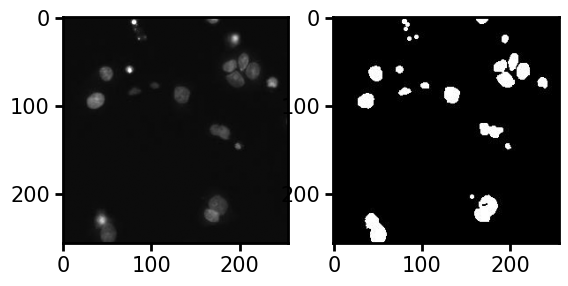

In [26]:
idx = 20
cells, masks = load_img(paths[idx])
fig, axes = plt.subplots(1,2)
axes[0].imshow(cells, cmap='gray')
axes[1].imshow(masks, cmap='gray')

Your ImageDataset class.

In [27]:
################ Code #################
class ImageDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img, mask = load_img(img_path)

        img = self.transform(img)
        mask = transforms.ToTensor()(mask)

        return img, mask


Split your data and load your DataLoaders.


In [29]:
################ Code #################
train_val_paths, test_paths = train_test_split(paths, test_size=0.2, random_state=42)
train_paths, val_paths = train_test_split(train_val_paths, test_size=0.125, random_state=42)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

train_dataset = ImageDataset(train_paths, transform=train_transform)
val_dataset = ImageDataset(val_paths)
test_dataset = ImageDataset(test_paths)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Is it necessary to apply random translation to your images? Briefly justify your answer.


In this task, random rotation may not be necessary for data augmentation, since the dataset already includes cell images with diverse orientations.

### 2.2 (20 points) Train a U-Net Model that Performs Image Segmentation

Implement Dice loss.

In [35]:
def dice_loss(pred, target):
    """Calculate Dice loss.

    Parameters
    ----------
        pred:
            predictions from the model
        target:
            ground truth label
    """

    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + 1.) / (pred.sum() + target.sum() + 1.)

    return 1 - dice
################ Code #################

The U-Net Model.


In [36]:
class DownSampling(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, name=None):
        super(DownSampling, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):

        conv_out = self.conv(x)
        output = self.max_pool(conv_out)

        return output, conv_out


class UpSampling(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, name=None):
        super(UpSampling, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size)
        self.conv_t = nn.ConvTranspose2d(out_channels, out_channels, kernel_size, \
                                         padding=1, stride=2, output_padding=1)


    def forward(self, x, skip):

        conv_out = self.conv(x)
        output = self.conv_t(conv_out)

        output += skip

        return output


class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, padding=1, stride=1, name=None):
        super(ConvBlock, self).__init__()

        block = []
        # first conv layer
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size, \
                               padding=padding, stride=stride))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_channels))

        # second conv layer
        block.append(nn.Conv2d(out_channels, out_channels, kernel_size, \
                               padding=padding, stride=stride))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_channels))

        # make sequential
        self.conv_block = nn.Sequential(*block)


    def forward(self, x):

        output = self.conv_block(x)

        return output


class UNet(nn.Module):

    def __init__(self, num_kernel=8, kernel_size=3, dim=1, target_dim=1):
        """UNet

        Arguments:
            num_kernel: int
                number of kernels to use for the first layer
            kernel_size: int
                size of the kernel for the first layer
            dims: int
                number of color channels for input images
            target_dim: int
                number of channels for the output mask
        """

        super(UNet, self).__init__()

        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = 1

        # encode
        self.encode_1 = DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):

        has_channel = x.ndim == 4
        if not has_channel:
            x = x.unsqueeze(1)

        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)

        pred = self.activate(x)

        if not has_channel:
            pred = pred.squeeze(1)

        return pred


    def args_dict(self):
        """model arguments to be saved
        """

        model_args = {'dim': self.dim,
                      'target_dim': self.target_dim,
                      'num_kernel' : self.num_kernel,
                      'kernel_size' : self.kernel_size}

        return model_args

Example model usage.

In [37]:
model = UNet()
y = model(torch.randn(4, 256, 256))

print(y.shape)

torch.Size([4, 256, 256])


A function to plot a segmentation map.


In [38]:
def plot_seg(img, pred_seg, true_seg, mask_cutoff=0.5):

    """ Visualize segmentation results.
    Inputs:
        image: orginal image, shape: 256 x 256
        pred_seg: predicted mask, shape: 256 x 256
        true_seg: true mask, shape: 256 x 256
        mask_cutoff: if the mask values is larger than mask_cutoff, the mask will appear on the image
    """
    img = img.squeeze()
    pred_seg = pred_seg.squeeze()
    true_seg = true_seg.squeeze()

    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
    fig.set_size_inches((15,15))

    ax[0].set_title("Original Image")
    ax[1].set_title("Prediction")
    ax[2].set_title("Ground Truth")

    img = np.stack([img,img,img],axis = -1)
    ax[0].imshow(img)
    ax[1].imshow(np.clip(color.label2rgb(pred_seg > mask_cutoff,img,colors=[(255,0,0)],alpha=0.0025, bg_label=0, bg_color=None),0,1))
    ax[2].imshow(np.clip(color.label2rgb(true_seg > mask_cutoff,img,colors=[(255,0,0)],alpha=0.0025, bg_label=0, bg_color=None),0,1))

    plt.show()

Train your model.

In [ ]:
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for img, mask in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{epochs}"):
        img = img.to(device).float()
        mask = mask.to(device).float()

        pred = model(img)
        loss = dice_loss(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for img, mask in val_loader:
            img = img.to(device).float()
            mask = mask.to(device).float()

            pred = model(img)
            loss = dice_loss(pred, mask)
            val_epoch_loss += loss.item()

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)


[Train] Epoch 20/20: 100%|██████████| 59/59 [00:01<00:00, 47.05it/s]


Show segmentation results for 3 images from the test dataset.


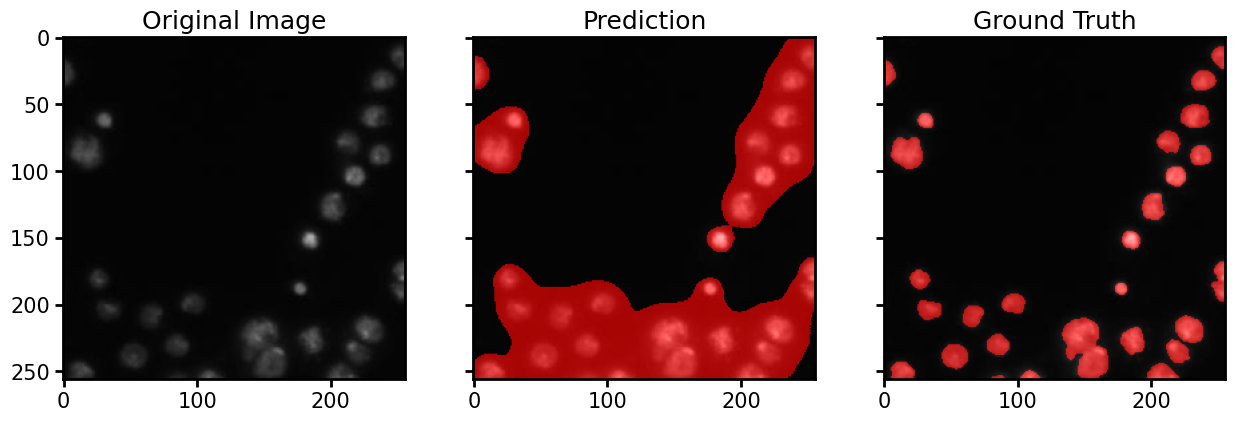

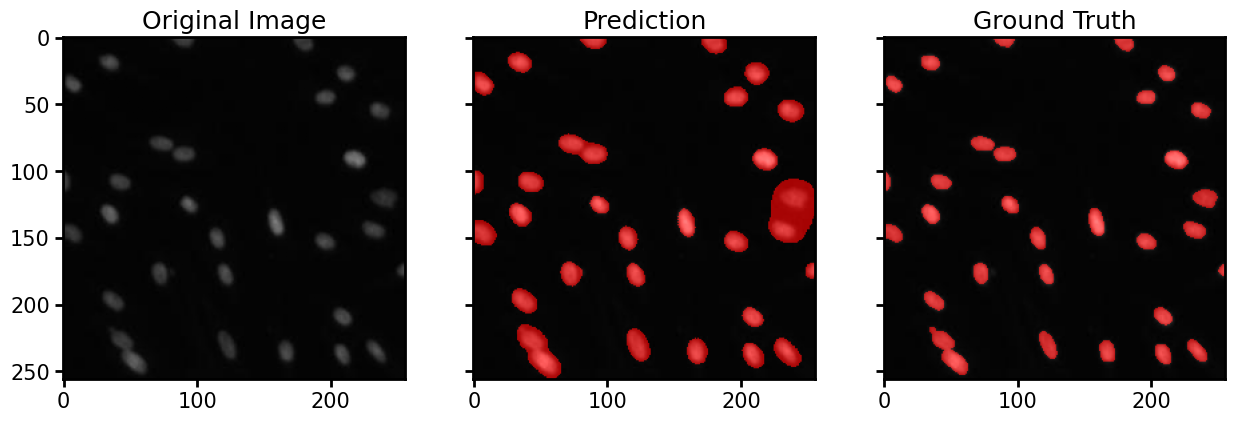

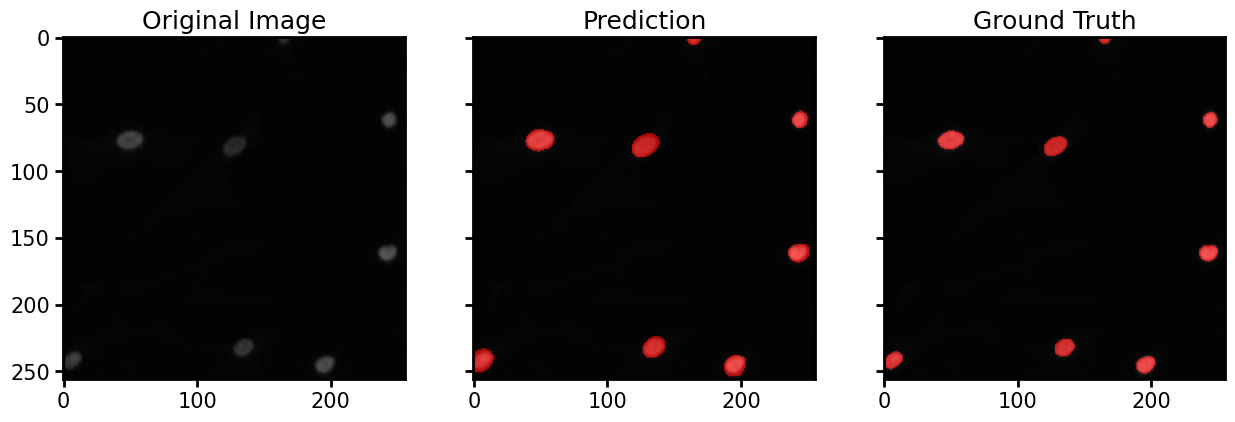

In [ ]:
model.eval()
with torch.no_grad():

    all_imgs = []
    all_masks = []

    for img, mask in test_loader:
        all_imgs.append(img)
        all_masks.append(mask)

    all_imgs = torch.cat(all_imgs, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    indices = random.sample(range(len(all_imgs)), 3)

    for idx in indices:
        img = all_imgs[idx].unsqueeze(0).to(device).float()
        true_mask = all_masks[idx].squeeze().numpy()

        pred_mask = model(img).squeeze().cpu().numpy()
        input_img = img.squeeze().cpu().numpy()

        plot_seg(input_img, pred_mask, true_mask)